In [1]:
# Dependencies
import json
import numpy as np
from datetime import datetime
import time as time
import matplotlib.pyplot as plt
import pandas as pd
import requests as req
import zipcodes
import http.client 

In [2]:
#read zip code file and verify the zip is valid
all_zips = pd.read_csv("Resources/free-zipcode-database-Primary.csv")
all_zips.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
3,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN
4,602,STANDARD,AGUADA,PR,PRIMARY,18.38,-67.18,NA-US-PR-AGUADA,False,NaN,NaN,NaN


In [3]:

# get latitude and longitude of target zipcode for use with google places
target_zip = input("Which zipcode would you like to score? ")

#make sure the zip code is in the valid zip code file
if any(all_zips["Zipcode"] == int(target_zip)):
        
    print("valid zip")

else:
    print("That is not a valid zip code")
    target_zip = input("Please try a new zipcode ")


lat = zipcodes.matching(target_zip)[0]["lat"]
lng = zipcodes.matching(target_zip)[0]["long"]
city = zipcodes.matching(target_zip)[0]["city"].lower()
state = zipcodes.matching(target_zip)[0]["state"].lower()

Which zipcode would you like to score? 22201
valid zip


In [4]:
# Function to store Zillow home values and monthly rental prices for 2013-2017 quarters
# Function requires a zip code string; returns data frame

def get_home_data(zipc):
    zip_code = int(zipc)
    
    #create lists for the Zillow data 
    home_values=[]
    monthly_rentals=[]
    periods = []
    years=["2013","2014","2015","2016","2017"]
    months=["03","06","09","12"]
    
    
    ## Zillow Home Value Index (ZHVI) is a time series tracking the monthly median home value
    # get the data just for the input zip code
    all_homes = pd.read_csv("Resources/Zip_Zhvi_AllHomes.csv")
    zc_all_homes = all_homes[all_homes["RegionName"] == zip_code].iloc[0]

    ## Zillow Rental Index (ZRI) is a time series tracking the monthly median rental
    all_rental_homes = pd.read_csv("Resources/Zip_Zri_AllHomes.csv")
    zc_all_rental_homes = all_rental_homes[all_rental_homes["RegionName"] == zip_code].iloc[0]
    
    #get the home value and monthly rental data for the years/months specified above
    for y in years:
        for m in months:
            col_name = "%s-%s" % (y,m)

            try:
                #get the data for this column name
                home_value = zc_all_homes[col_name]
                rent = zc_all_rental_homes[col_name]
                home_values.append(home_value)
                monthly_rentals.append(rent)
                periods.append(col_name)
                #print(col_name, home_value, rent)
            except:
                print("no value for: %s" % col_name)
                    
    #store rent and house prices into a DF
    zillow_df=pd.DataFrame({"period": periods, 
                        "home_value": home_values,
                        "monthly_rent": monthly_rentals})
    return zillow_df, periods                  

In [5]:
df, periods = get_home_data(target_zip)

no value for: 2017-12


In [6]:
# Function to plot Zillow home values and monthly rental prices for 2013-2017 quarters
# Function requires a DF with the Zillow info and the zip code (string)
def plot_homes(df, zipc, periods):
    #plot the home values 
    x_ticks = periods
    x_axis = np.arange(1,20,1)
    y_axis = df['home_value']
    plt.xticks(x_axis, x_ticks, rotation='vertical')
    plt.legend
    plt.plot(x_axis, y_axis)
    plt.ylabel("Home Prices ($)")
    plt.title("%s Home Sales 2013-2017" % zipc)
    #save the plot??
    plt.show()
    
    #plot the monthly rentals
    x_ticks = periods
    x_axis = np.arange(1,20,1)
    y_axis = df['monthly_rent']
    plt.xticks(x_axis, x_ticks, rotation='vertical')
    plt.legend
    plt.plot(x_axis, y_axis)
    plt.xlabel("Recent Quarters")
    plt.ylabel("Montly Rents ($)")
    plt.title("%s Monthly Rents 2013-2017" % zipc)
    plt.show()

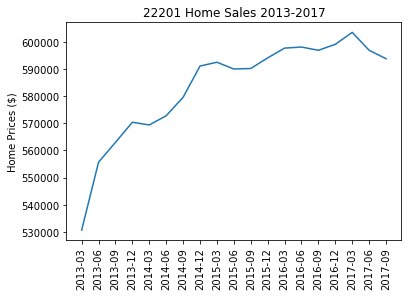

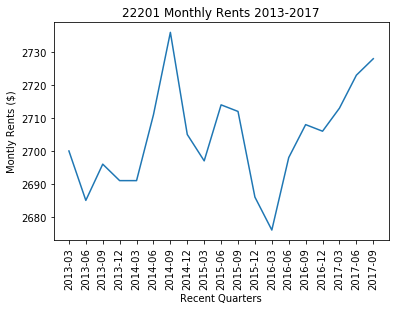

In [7]:
plot_homes(df,target_zip,periods)

In [8]:
#### THIS FUNCTION WILL NOT BE IN THIS FILE! 
#### IT WILL BE CALLED ONLY ONCE FROM THE MAIN FILE; IT'S JUST HERE FOR NOW FOR TESTING
def get_community_data(target_zip):
    import http.client 
   #Onboard API Key
    onboard_api_key = "727ca1bf9168cb8329806cb7e0eef3f6"
    conn = http.client.HTTPSConnection("search.onboard-apis.com")
    headers = {
        'accept': "application/json",
        'apikey': "727ca1bf9168cb8329806cb7e0eef3f6",
        } 
    community_url = "/communityapi/v2.0.0/Area/Full/?"
    queries="AreaId=ZI"+target_zip
    query_url = community_url + queries
    conn.request("GET", query_url, headers=headers) 
    res = conn.getresponse()
    resp = json.loads(res.read())
    
    return resp
    


In [9]:
#get_details(target_zip)  
def get_details(target_zip):
    
    resp = get_community_data(target_zip)
        
    #store the individual fields in a dictionary
    
    crime = resp['response']['result']['package']['item'][0]['crmcytotc']
    sales_tax= resp['response']['result']['package']['item'][0]['salestaxrate']
    avg_jan = resp['response']['result']['package']['item'][0]['tmpavejan']
    avg_jul = resp['response']['result']['package']['item'][0]['tmpavejul']
            
    return crime, sales_tax, avg_jan, avg_jul

In [10]:
# Function to store various information about a location, such as walkability score, market health index, schools
# Function requires a zip code string, latitude and longitude; returns ?
def get_zip_factors (zipc, lat, lng):
    
    #factors dictionary to return
    zip_factors_dict = {}
    
    #1) Market Health Index: 
    # This index indicates the current health of a given region’s housing market relative to other markets nationwide. 
    # It is calculated on a scale of 0 to 10, with 0 = the least healthy markets and 10 = the healthiest markets.
    market_health_index = pd.read_csv("Resources/MarketHealthIndex_Zip.csv",encoding="ISO-8859-1")
    
    try:
        zip_market_health = market_health_index[market_health_index["RegionName"] == int(zipc)].iloc[0]
        market_health = zip_market_health['MarketHealthIndex']
        print("Market Health: %s" % market_health)
        zip_factors_dict["Market Health"] = market_health
    except:
        #no market health data for input zip code; store 0 as a N/A value
        zip_factors_dict["Market Health"] = 0
    
    #2) ##get walkability, transit and bike scores from Walk Score once I have an API.
    walk_api_key = "ca8240c847695f334874949c406f04aa"
    walk_url = "http://api.walkscore.com/score?format=json&"
    # Build query URL
    query_url = walk_url  + "&lat=" + str(lat) + "&lon=" + str(lng) + "&transit=1&bike=1" + "&wsapikey=" + walk_api_key
    walk_response = req.get(query_url).json()

    # Get the neighborhood data from the response
    walk_score = walk_response['walkscore']
    walk_description=walk_response['description']
    
    zip_factors_dict["walk_score"] = walk_score
    zip_factors_dict["walk_description"] = walk_description
    
    try:    
        bike_score = walk_response['bike']['score']
        bike_description = walk_response['bike']['description']
        zip_factors_dict["bike_score"] = bike_score
        zip_factors_dict["bike_description"] = bike_description
    except:
        print("no bike score")
        bike_score = 0
        bike_description = ""
    print("Walkability and Bikability Scores: %s: %s, %s: %s" % (walk_score, walk_description, bike_score, bike_description))

    #get community data and store in dictionary
    crime, salestax, avgtempJan, avgtempJul = get_details(target_zip)
    zip_factors_dict["crime_risk"] = crime
    zip_factors_dict["sales_tax_rate"] = salestax
    zip_factors_dict["avg_temp_Jan"] = avgtempJan
    zip_factors_dict["avg_temp_Jul"] = avgtempJul
    
    print("crime risk: %s" % crime)
    
get_zip_factors(target_zip,lat, lng)    

Market Health: 2.53389168855
Walkability and Bikability Scores: 73: Very Walkable, 73: Very Bikeable
crime risk: 95


In [11]:
#Get school data from OnBoard
# Function requires latitude and longitude; returns ?
def get_school_data(lat, lng):
    import http.client 

    #Onboard API Key
    onboard_api_key = "727ca1bf9168cb8329806cb7e0eef3f6"

    conn = http.client.HTTPSConnection("search.onboard-apis.com") 
    school_url = "/propertyapi/v1.0.0/school/snapshot?"
    headers = { 
        'accept': "application/json", 
        'apikey': "727ca1bf9168cb8329806cb7e0eef3f6", 
        } 

    point = "latitude=" + str(lat) + "&longitude=" + str(lng) + "&radius=5"
    query_url = school_url + point

    conn.request("GET", query_url, headers=headers) 

    res = conn.getresponse()
    resp = json.loads(res.read())
    resp
    
    #loop through and count up private and public schools
    total = resp['status']['pagesize']
    print(total)
    for i in range(0, total):    
        print("Type: %s, Name: %s" % (resp['school'][i]['School']['Filetypetext'], resp['school'][i]['School']['InstitutionName']))
        #print(resp['school'][i]['School']['InstitutionName'])

    #What do we want to return from this function? number of schools of each type? all requests seem to return 10 total
    
get_school_data(lat,lng)    

10
Type: PUBLIC, Name: JEFFERSON MIDDLE SCHOOL
Type: CATHOLIC, Name: ST. THOMAS MORE CATHEDRAL SCHOOL
Type: PUBLIC, Name: HENRY ELEMENTARY SCHOOL
Type: PUBLIC, Name: LONG BRANCH ELEMENTARY SCHOOL
Type: PUBLIC, Name: BARRETT ELEMENTARY SCHOOL
Type: PRIVATE, Name: CHESTERBROOK MONTESSORI SCHOOL-ARLINGTON FOREST
Type: PRIVATE, Name: OUR SAVIOR LUTHERAN SCHOOL
Type: PUBLIC, Name: BARCROFT ELEMENTARY SCHOOL
Type: PUBLIC, Name: ARLINGTON COMMUNITY HIGH SCHOOL
Type: PUBLIC, Name: GOVERNOR'S ACADEMY FOR CAREER AND TECHNICAL EDUCATION IN ARLINGTON
